In [1]:
import numpy as np
from re import sub
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_dir = "C:/Users/Gagan/Desktop/DATA/Train"
val_dir = "C:/Users/Gagan/Desktop/DATA/Val"
test_dir = "C:/Users/Gagan/Desktop/DATA/Test"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                            image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(val_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                                  batch_size=BATCH_SIZE,
                                             seed = 42,
                                                 image_size=IMG_SIZE)

Found 2192 files belonging to 2 classes.
Found 232 files belonging to 2 classes.


In [3]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ": ", class_names[i - 1])

1:  Autistic
2:  NonAutistic


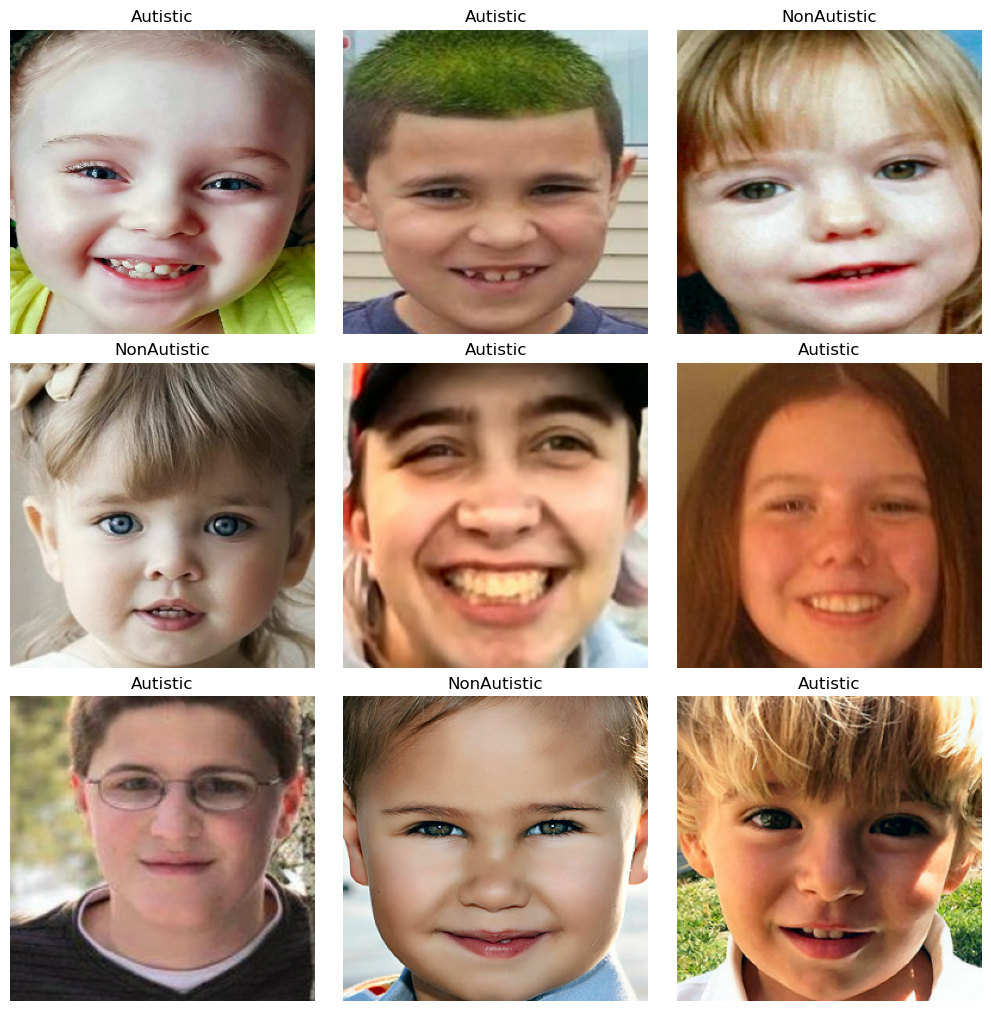

In [4]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = image_dataset_from_directory(val_dir,
                                             shuffle=True,
                                             label_mode = 'categorical')

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 232 files belonging to 2 classes.
Number of validation batches: 15
Number of test batches: 8


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
]

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 6, 6, 1536)


In [11]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(16, 1536)


In [12]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 2)


In [13]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

In [16]:
initial_epochs = 20

In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


C:\Users\Gagan\anaconda3\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


137/137 [==============================] - 271s 2s/step - loss: 0.6727 - accuracy: 0.6218 - precision: 0.6218 - recall: 0.6218 - val_loss: 0.5607 - val_accuracy: 0.6983 - val_precision: 0.6983 - val_recall: 0.6983
Epoch 2/20
137/137 [==============================] - 282s 2s/step - loss: 0.6027 - accuracy: 0.6756 - precision: 0.6756 - recall: 0.6756 - val_loss: 0.5493 - val_accuracy: 0.7112 - val_precision: 0.7112 - val_recall: 0.7112
Epoch 3/20
137/137 [==============================] - 275s 2s/step - loss: 0.5723 - accuracy: 0.7012 - precision: 0.7012 - recall: 0.7012 - val_loss: 0.5293 - val_accuracy: 0.7112 - val_precision: 0.7112 - val_recall: 0.7112
Epoch 4/20
137/137 [==============================] - 266s 2s/step - loss: 0.5667 - accuracy: 0.7153 - precision: 0.7153 - recall: 0.7153 - val_loss: 0.5039 - val_accuracy: 0.7026 - val_precision: 0.7026 - val_recall: 0.7026
Epoch 5/20
137/137 [==============================] - 275s 2s/step - loss: 0.5782 - accuracy: 0.7044 - precisio

In [18]:
result = model.evaluate(test_dataset)
metrics = ["loss","accuracy", "precision", "recall"]
for i in range(len(result)):
    print("{} : {}%".format(metrics[i],(result[i])*100))

8/8 [==============================] - 32s 4s/step - loss: 0.4777 - accuracy: 0.7543 - precision: 0.7543 - recall: 0.7543
loss : 47.76817560195923%
accuracy : 75.43103694915771%
precision : 75.43103694915771%
recall : 75.43103694915771%


In [19]:
Test_Accuracy = result[1]

In [20]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, parameter in enumerate(metrics):
    name = parameter.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[parameter], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+parameter],
             color='blue', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if parameter == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

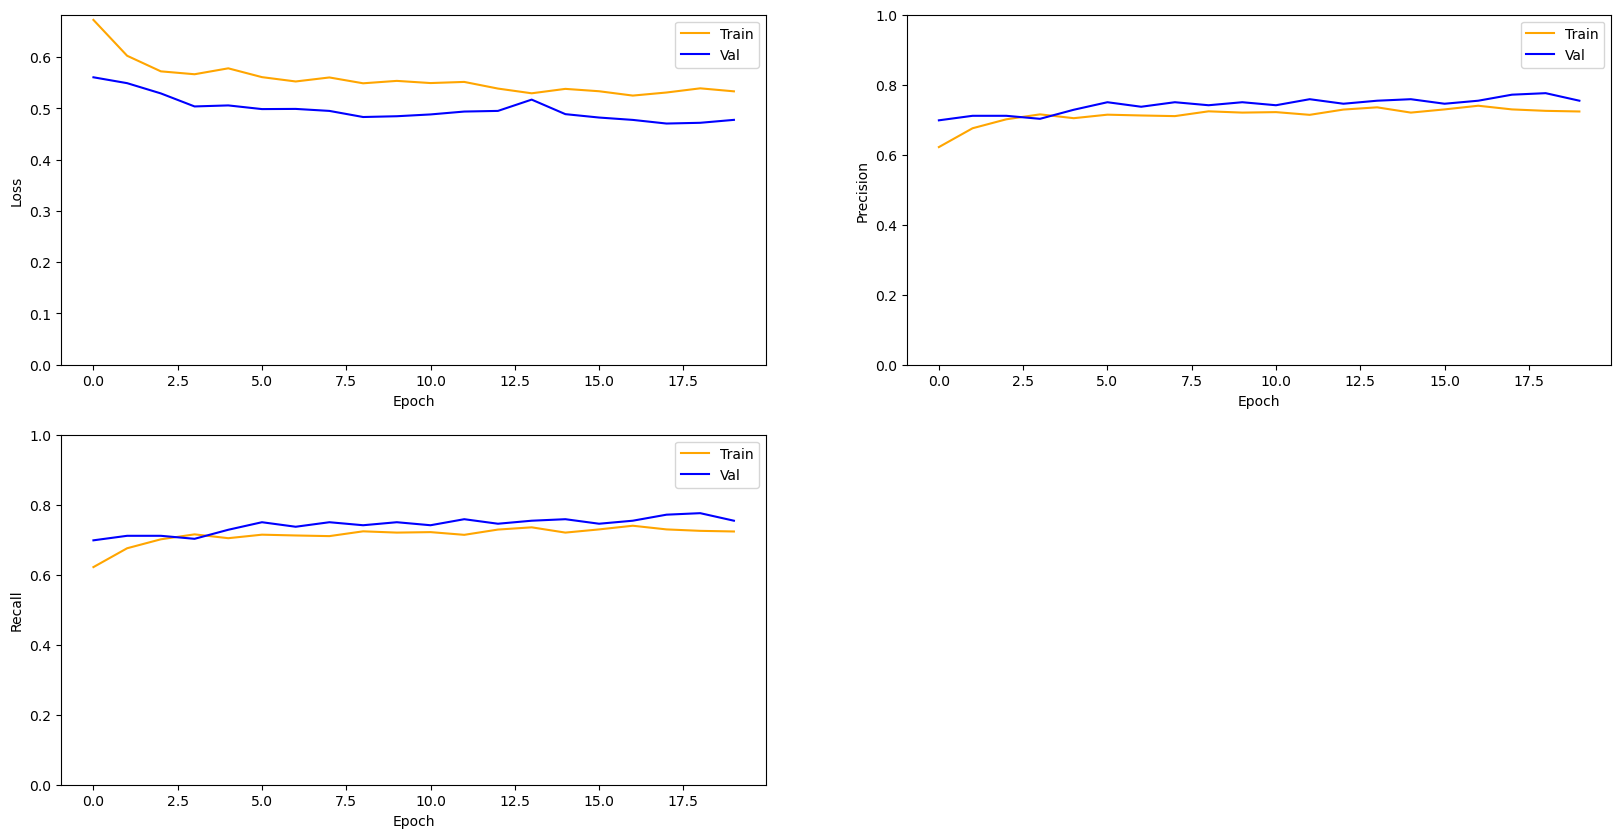

In [21]:
plot_metrics(history)

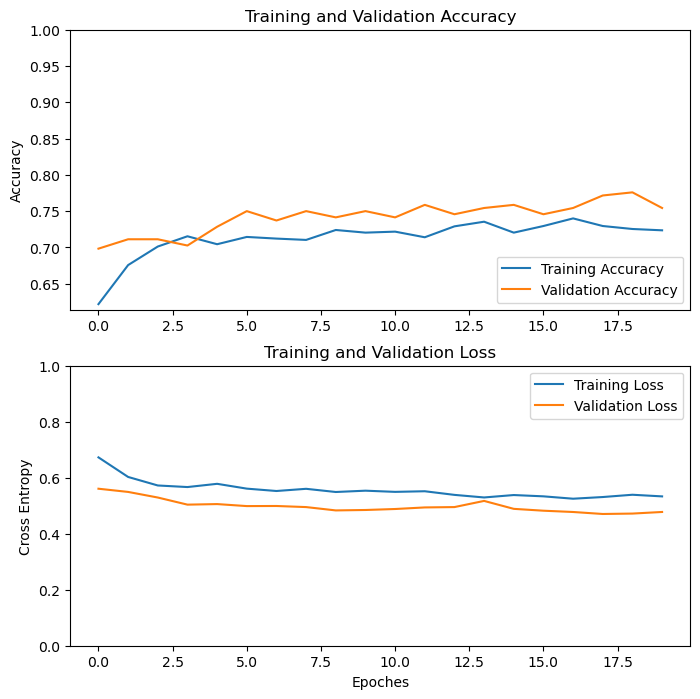

In [22]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoches')
plt.show()

In [23]:
print("Testing Accuracy : {} %".format((Test_Accuracy)*100))

Testing Accuracy : 75.43103694915771 %
